In [2]:
!pip install langchain

In [3]:
!pip install openai pypdf

In [4]:
!pip install --upgrade typing_extensions
!pip install openai
!pip install pypdf
!pip install langchain

In [5]:
pip install -U langchain-community

## VECTOR STORE

In [6]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pandas as pd

# Cargar el documento PDF
loader = PyPDFLoader("llm_doc.pdf")
documents = loader.load()

# Dividir el contenido en chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splits = text_splitter.split_documents(documents)

# Crear un DataFrame para almacenar los chunks y metadatos
data = [{'Chunks': doc.page_content, 'Metadata': doc.metadata} for doc in doc_splits]
df_vector_store = pd.DataFrame(data)


## CREACIÓN DE PREGUNTAS Y RESPUESTAS

In [7]:
import pandas as pd

# Preguntas y respuestas propuestas basadas en el contenido de llm_doc.pdf
questions_answers = {
    "Pregunta": [
        "¿Qué son los LLMs?",
        "¿Qué es LLMOps?",
        "¿Por qué usar modelos preentrenados?",
        "¿Qué retos enfrenta el uso de LLMs?",
        "¿Qué es el aprendizaje cero disparos (ZSL)?",
        "¿Cuál es la ventaja del ajuste eficiente de parámetros?",
        "¿Qué evalúa el puntaje METEOR?",
        "¿Qué es la distilación de modelos?"
    ],
    "Respuesta": [
        "Modelos basados en transformadores para procesar y generar lenguaje natural.",
        "Un marco para gestionar el ciclo de vida de aplicaciones basadas en LLMs.",
        "Ahorran recursos al adaptarse a tareas específicas con menos datos.",
        "Costos, latencia, compatibilidad, privacidad y manejo de lenguajes ambiguos.",
        "Predecir sin usar muestras de entrenamiento previas.",
        "Evita olvidar tareas previas al cambiar pesos.",
        "Calidad basada en alineación de texto generado y referencia.",
        "Transferir conocimientos a un modelo optimizado."
    ]
}

# Crear un DataFrame y guardar en un archivo Excel
df_questions = pd.DataFrame(questions_answers)
df_questions.to_excel("preguntas_respuestas.xlsx", index=False)
print("Archivo 'preguntas_respuestas.xlsx' generado con éxito.")


Archivo 'preguntas_respuestas.xlsx' generado con éxito.


## EMBEDDINGS PARA EL VECTOR STORE

In [9]:
from openai import OpenAI
import numpy as np
import pandas as pd
import json

file_name = open('credentials.json')
config_env = json.load(file_name)
api_key = config_env["openai_key"]
client = OpenAI(api_key=api_key)

In [ ]:
# Función para generar embeddings
def text_embedding(text=[]):
    embeddings = client.embeddings.create(model="text-embedding-ada-002", input=text,encoding_format="float")
    return embeddings.data[0].embedding

# Calcular embeddings para el Vector Store
df_vector_store["Embedding"] = df_vector_store["Chunks"].apply(lambda x: text_embedding([x]))
df_vector_store["Embedding"] = df_vector_store["Embedding"].apply(np.array)

# Guardar el DataFrame 'df_vector_store' en un pkl
df_vector_store.to_pickle('df_vector_store.pkl')
df_vector_store.head()

In [105]:
df_questions = pd.DataFrame(questions_answers)
df_questions.to_excel("preguntas_respuestas.xlsx", index=False)
df_questions.head()

,Pregunta,Respuesta
0,¿Qué son los LLMs?,Modelos basados en transformadores para proces...
1,¿Qué es LLMOps?,Un marco para gestionar el ciclo de vida de ap...
2,¿Por qué usar modelos preentrenados?,Ahorran recursos al adaptarse a tareas específ...
3,¿Qué retos enfrenta el uso de LLMs?,"Costos, latencia, compatibilidad, privacidad y..."
4,¿Qué es el aprendizaje cero disparos (ZSL)?,Predecir sin usar muestras de entrenamiento pr...


## CONTEXTO

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def get_context_from_query(query, vector_store, n_chunks=5):
    # Obtener el embedding de la pregunta
    query_embedding = np.array(text_embedding([query]))  # Generar el embedding para la pregunta
    # Calcular similitud de coseno entre la pregunta y los chunks en el vector store
    vector_store['CosineSimilarity'] = vector_store['Embedding'].apply(
        lambda x: cosine_similarity([x], [query_embedding])[0][0]
    )

    top_matches = vector_store.sort_values(by='CosineSimilarity', ascending=False).head(n_chunks)
    context_list = top_matches['Chunks'].tolist()  # Extraer los textos más relevantes
    return context_list


## RESPUESTAS DEL CHATBOT

In [10]:
def generar_respuesta_gpt4(query, context_list):
    # Crear el prompt para el modelo GPT-4 con el contexto y la pregunta
    custom_prompt = f"""
    Eres una Inteligencia Artificial avanzada.
    Utiliza los siguientes fragmentos de texto para responder la pregunta de manera precisa:

    CONTEXTO:
    {str(context_list)}

    PREGUNTA:
    {query}

    Responde de forma breve y clara.
    """
    
    # Llamar a GPT-4 para obtener la respuesta
    completion = client.chat.completions.create(
        model="gpt-4",
        temperature=0.0,
        messages=[
            {"role": "system", "content": custom_prompt},
            {"role": "user", "content": query}
        ]
    )
    
    # Obtener la respuesta generada
    return completion.choices[0].message.content

## SIMILITUD DEL COSENO

In [108]:
def calcular_similitud(respuesta_generada, respuesta_propuesta):
    # Obtener los embeddings de las respuestas generadas y propuestas
    emb_chat = np.array(text_embedding([respuesta_generada])).reshape(1, -1)  # Embedding de la respuesta generada
    emb_propuesta = np.array(text_embedding([respuesta_propuesta])).reshape(1, -1)  # Embedding de la respuesta propuesta
    
    # Calcular la similitud de coseno
    similitud = cosine_similarity(emb_propuesta, emb_chat)[0][0]
    return similitud

## ACCURACY

In [ ]:
# Lista para almacenar los resultados de similitud
similitudes = []

# Iterar sobre todas las preguntas y calcular la similitud
for i in range(len(df_questions)):
    query = df_questions['Pregunta'][i]  # Obtener la pregunta actual
    respuesta_propuesta = df_questions['Respuesta'][i]  # Obtener la respuesta propuesta
    
    # Obtener el contexto relevante para la pregunta
    context_list = get_context_from_query(query, df_vector_store, n_chunks=5)
    
    # Generar la respuesta con GPT-4
    resp_chatbot = generar_respuesta_gpt4(query, context_list)
    
    # Calcular la similitud de coseno
    similitud = calcular_similitud(resp_chatbot, respuesta_propuesta)
    
    # Almacenar la similitud
    similitudes.append(similitud)

# Añadir la similitudes al DataFrame
df_questions['Similitud'] = similitudes

# Calcular el accuracy
threshold = 0.8  # Umbral de similitud
df_questions['Correcta'] = df_questions['Similitud'] >= threshold
accuracy = df_questions['Correcta'].mean()
print(f"Accuracy del chatbot: {accuracy:.2%}")


Accuracy del chatbot: 87.50%


In [115]:
df_questions.head()


,Pregunta,Respuesta,Similitud,Correcta
0,¿Qué son los LLMs?,Modelos basados en transformadores para proces...,0.878320,True
1,¿Qué es LLMOps?,Un marco para gestionar el ciclo de vida de ap...,0.831480,True
2,¿Por qué usar modelos preentrenados?,Ahorran recursos al adaptarse a tareas específ...,0.830761,True
3,¿Qué retos enfrenta el uso de LLMs?,"Costos, latencia, compatibilidad, privacidad y...",0.865407,True
4,¿Qué es el aprendizaje cero disparos (ZSL)?,Predecir sin usar muestras de entrenamiento pr...,0.824796,True


## GRÁFICO ACCURACY

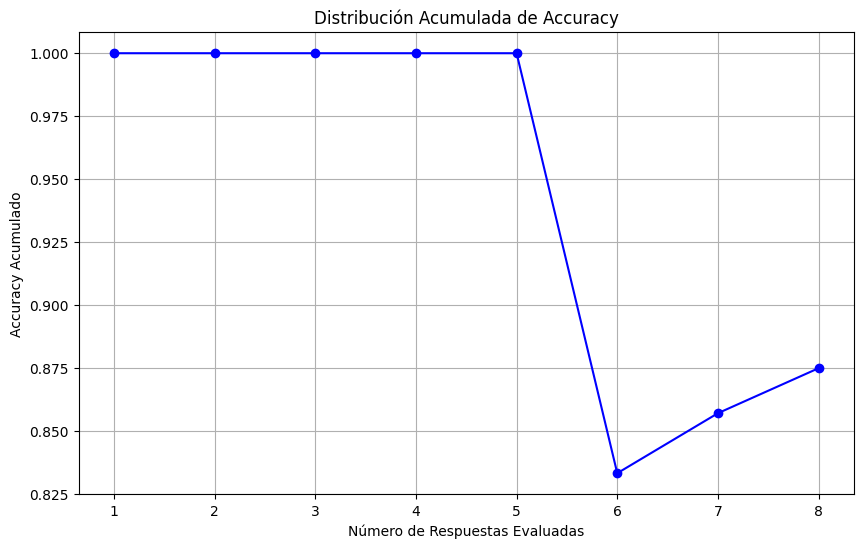

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular la precisión acumulada
accumulated_accuracy = df_questions['Correcta'].cumsum() / (df_questions.index + 1)

# Graficar la distribución acumulada
plt.figure(figsize=(10, 6))
plt.plot(df_questions.index + 1, accumulated_accuracy, marker='o', linestyle='-', color='b')
plt.title('Distribución Acumulada de Accuracy')
plt.xlabel('Número de Respuestas Evaluadas')
plt.ylabel('Accuracy Acumulado')
plt.grid(True)
plt.show()
